In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

In [2]:
# LSTM Implimentation
from tensorflow.keras.layers import Embedding,SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from keras.layers.convolutional import Conv1D  
from keras.optimizers import SGD

In [3]:
data_for_lstm = pd.read_csv('../Data/Updated Data_V1.csv')

In [4]:
data_for_lstm.drop('Unnamed: 0',inplace=True,axis = 1)

In [5]:
data_for_lstm.head(2)

,articleID,label,headline_v4,headline_postag,headline_stem
0,1,0,মুরগির হামলায় শেয়াল নিহত,মুরগির/NC হামলায়/NC শেয়াল/NC নিহত/JJ,মুগি হামলা শেয়াল নিহত
1,2,0,বিটিভিতে যেবার ইন্টারভিউ গেলাম,বিটিভিতে/NC যেবার/NV ইন্টারভিউ/NC গেলাম/VM,বিটিভিতে যেবা ইন্টারভিউ গে


In [6]:
data = data_for_lstm['headline_stem'].copy()

In [7]:
corpus = []
for i in range(0, len(data)):
    review = data[i]
    review = review.split()
    review = ' '.join(review)
    corpus.append(review)

In [8]:
voc_size = 20000
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr

[[14476, 3281, 15804, 17309],
 [5414, 6914, 11101, 5057],
 [7164, 11647, 16476, 11515, 7416, 18399, 13859, 1976],
 [6263, 15039, 5485, 19635],
 [16861, 3072, 8054, 8491, 19097, 19677],
 [12954, 2466, 13721, 19525, 14716, 12246, 11617],
 [19884, 19338, 16224, 2051, 4261, 15667],
 [6207, 11902, 6121, 3810, 13034, 17110, 19097, 19677],
 [15105, 7336, 4415, 8616, 9353, 3254],
 [19596, 5224, 6741, 14254, 19097, 19677],
 [19152, 17792, 14907, 4245, 17371, 8689, 3735, 11733, 13337],
 [8233, 12078, 16509, 19097, 19677],
 [9889, 17725, 9099, 6865, 14505, 13373, 10777, 15098, 16541],
 [11646, 19104, 2283, 14867, 6248, 19097, 19677],
 [6049, 5949, 4261, 8070, 10972, 105, 3473, 9867, 8070],
 [6186, 16184, 5776, 7106, 15761, 5248, 15963],
 [15308, 10603, 15163, 12682],
 [3314, 1524, 10499, 3361, 2255, 7079, 4798],
 [17326, 16258, 17439, 1076, 1826, 113, 2007, 7653, 6698, 19097, 19677],
 [19215, 18262, 5938, 2470, 16591, 5077],
 [11084, 5949, 7190, 662, 17309],
 [5182, 399, 19841, 13908, 18838, 1155

In [9]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)

In [10]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(data_for_lstm['label'])

In [11]:
from imblearn.combine import SMOTETomek
smk_tiagram = SMOTETomek(random_state=42)
X_vec_v1,Y_vec_v1=smk_tiagram.fit_sample(X_final,y_final)

In [12]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y_final)))
print('Resampled dataset shape {}'.format(Counter(Y_vec_v1)))

Original dataset shape Counter({1: 52588, 0: 4527})
Resampled dataset shape Counter({0: 52109, 1: 52109})


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vec_v1, Y_vec_v1, test_size=0.30, random_state=42)

In [15]:
from keras.models import Sequential
from keras.layers import Embedding,Bidirectional, Dense,Dropout

embedding_vector_features=128
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(SpatialDropout1D(0.4))
model1.add(Bidirectional(LSTM(256)))
model1.add(Dropout(0.2))
model1.add(Dense(2,activation='softmax'))
model1.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 128)           2560000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               788480    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 3,349,506
Trainable params: 3,349,506
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=128)

Epoch 1/5
570/570 [==============================] - 152s 268ms/step - loss: 0.3007 - accuracy: 0.8766 - val_loss: 0.2348 - val_accuracy: 0.9144
Epoch 2/5
570/570 [==============================] - 167s 294ms/step - loss: 0.1867 - accuracy: 0.9353 - val_loss: 0.2414 - val_accuracy: 0.9112
Epoch 3/5
570/570 [==============================] - 156s 274ms/step - loss: 0.1485 - accuracy: 0.9504 - val_loss: 0.2793 - val_accuracy: 0.9057
Epoch 4/5
570/570 [==============================] - 163s 286ms/step - loss: 0.1244 - accuracy: 0.9570 - val_loss: 0.3007 - val_accuracy: 0.9055
Epoch 5/5
570/570 [==============================] - 149s 261ms/step - loss: 0.1061 - accuracy: 0.9611 - val_loss: 0.3423 - val_accuracy: 0.9016


In [50]:
y_pred=model1.predict_classes(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8999584359113726

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.86      0.90     15524
           1       0.87      0.94      0.90     15753

    accuracy                           0.90     31277
   macro avg       0.90      0.90      0.90     31277
weighted avg       0.90      0.90      0.90     31277



Epoch 1/5
733/733 [==============================] - 187s 255ms/step - loss: 0.2856 - accuracy: 0.8868 - val_loss: 0.2317 - val_accuracy: 0.9172
Epoch 2/5
733/733 [==============================] - 203s 277ms/step - loss: 0.1856 - accuracy: 0.9360 - val_loss: 0.2372 - val_accuracy: 0.9166
Epoch 3/5
733/733 [==============================] - 204s 278ms/step - loss: 0.1528 - accuracy: 0.9480 - val_loss: 0.2552 - val_accuracy: 0.9142
Epoch 4/5
733/733 [==============================] - 194s 265ms/step - loss: 0.1302 - accuracy: 0.9539 - val_loss: 0.2881 - val_accuracy: 0.9101
Epoch 5/5
733/733 [==============================] - 196s 268ms/step - loss: 0.1128 - accuracy: 0.9572 - val_loss: 0.3204 - val_accuracy: 0.9088


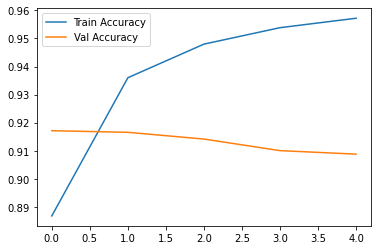

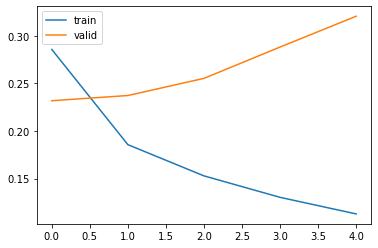

accuracy: 90.88%
Epoch 1/5
733/733 [==============================] - 203s 277ms/step - loss: 0.2876 - accuracy: 0.8842 - val_loss: 0.2168 - val_accuracy: 0.9230
Epoch 2/5
733/733 [==============================] - 224s 305ms/step - loss: 0.1883 - accuracy: 0.9351 - val_loss: 0.2264 - val_accuracy: 0.9206
Epoch 3/5
733/733 [==============================] - 221s 302ms/step - loss: 0.1553 - accuracy: 0.9469 - val_loss: 0.2300 - val_accuracy: 0.9190
Epoch 4/5
733/733 [==============================] - 244s 332ms/step - loss: 0.1329 - accuracy: 0.9525 - val_loss: 0.2579 - val_accuracy: 0.9159
Epoch 5/5
733/733 [==============================] - 250s 341ms/step - loss: 0.1153 - accuracy: 0.9565 - val_loss: 0.2898 - val_accuracy: 0.9143


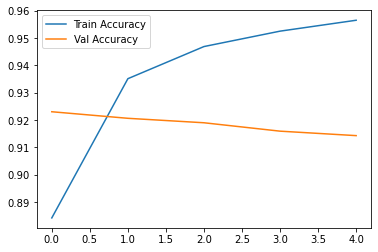

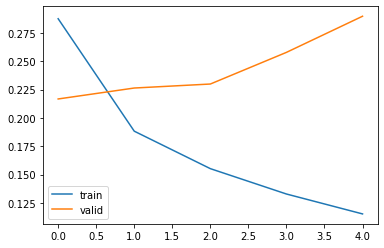

accuracy: 91.43%
Epoch 1/5
733/733 [==============================] - 243s 331ms/step - loss: 0.2821 - accuracy: 0.8858 - val_loss: 0.2365 - val_accuracy: 0.9146
Epoch 2/5
733/733 [==============================] - 246s 336ms/step - loss: 0.1865 - accuracy: 0.9354 - val_loss: 0.2447 - val_accuracy: 0.9135
Epoch 3/5
733/733 [==============================] - 233s 318ms/step - loss: 0.1512 - accuracy: 0.9488 - val_loss: 0.2741 - val_accuracy: 0.9105
Epoch 4/5
733/733 [==============================] - 237s 323ms/step - loss: 0.1296 - accuracy: 0.9541 - val_loss: 0.2958 - val_accuracy: 0.9088
Epoch 5/5
733/733 [==============================] - 236s 322ms/step - loss: 0.1134 - accuracy: 0.9577 - val_loss: 0.3068 - val_accuracy: 0.9054


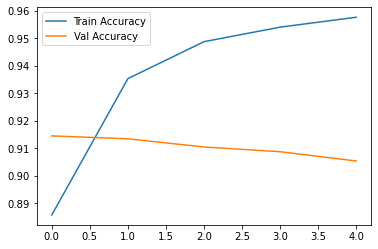

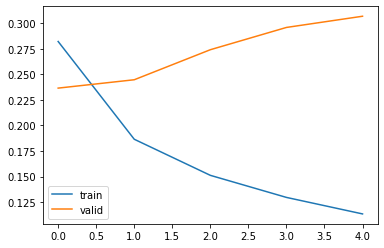

accuracy: 90.54%
Epoch 1/5
733/733 [==============================] - 240s 328ms/step - loss: 0.2833 - accuracy: 0.8875 - val_loss: 0.2342 - val_accuracy: 0.9137
Epoch 2/5
733/733 [==============================] - 314s 429ms/step - loss: 0.1842 - accuracy: 0.9363 - val_loss: 0.2397 - val_accuracy: 0.9116
Epoch 3/5
733/733 [==============================] - 340s 464ms/step - loss: 0.1515 - accuracy: 0.9486 - val_loss: 0.2645 - val_accuracy: 0.9075
Epoch 4/5
733/733 [==============================] - 340s 464ms/step - loss: 0.1314 - accuracy: 0.9540 - val_loss: 0.2785 - val_accuracy: 0.9087
Epoch 5/5
733/733 [==============================] - 340s 463ms/step - loss: 0.1161 - accuracy: 0.9572 - val_loss: 0.3191 - val_accuracy: 0.9062


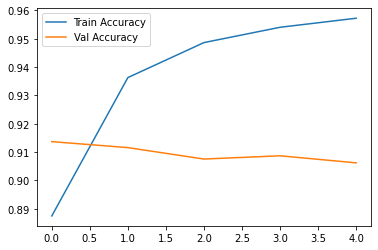

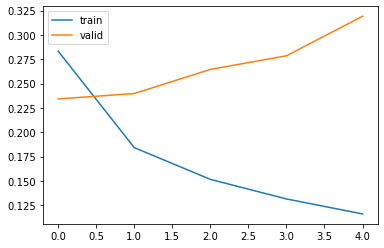

accuracy: 90.62%
Epoch 1/5
733/733 [==============================] - 355s 485ms/step - loss: 0.2879 - accuracy: 0.8852 - val_loss: 0.2292 - val_accuracy: 0.9138
Epoch 2/5
733/733 [==============================] - 360s 490ms/step - loss: 0.1857 - accuracy: 0.9360 - val_loss: 0.2352 - val_accuracy: 0.9163
Epoch 3/5
733/733 [==============================] - 341s 465ms/step - loss: 0.1516 - accuracy: 0.9485 - val_loss: 0.2468 - val_accuracy: 0.9133
Epoch 4/5
733/733 [==============================] - 351s 478ms/step - loss: 0.1305 - accuracy: 0.9540 - val_loss: 0.2811 - val_accuracy: 0.9091
Epoch 5/5
733/733 [==============================] - 382s 521ms/step - loss: 0.1152 - accuracy: 0.9571 - val_loss: 0.3158 - val_accuracy: 0.9065


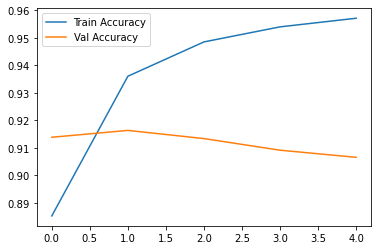

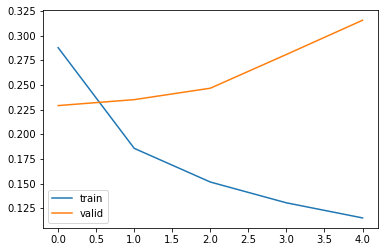

accuracy: 90.65%
Epoch 1/5
733/733 [==============================] - 358s 489ms/step - loss: 0.2852 - accuracy: 0.8858 - val_loss: 0.2195 - val_accuracy: 0.9213
Epoch 2/5
733/733 [==============================] - 333s 455ms/step - loss: 0.1857 - accuracy: 0.9353 - val_loss: 0.2257 - val_accuracy: 0.9195
Epoch 3/5
733/733 [==============================] - 301s 411ms/step - loss: 0.1520 - accuracy: 0.9492 - val_loss: 0.2432 - val_accuracy: 0.9165
Epoch 4/5
733/733 [==============================] - 300s 409ms/step - loss: 0.1311 - accuracy: 0.9539 - val_loss: 0.2793 - val_accuracy: 0.9115
Epoch 5/5
733/733 [==============================] - 298s 406ms/step - loss: 0.1130 - accuracy: 0.9576 - val_loss: 0.3293 - val_accuracy: 0.9098


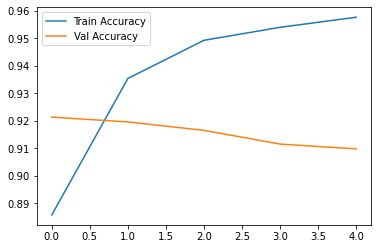

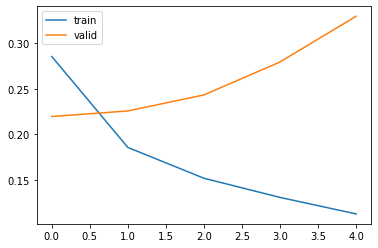

accuracy: 90.98%
Epoch 1/5
733/733 [==============================] - 324s 441ms/step - loss: 0.2845 - accuracy: 0.8878 - val_loss: 0.2332 - val_accuracy: 0.9132
Epoch 2/5
733/733 [==============================] - 321s 438ms/step - loss: 0.1855 - accuracy: 0.9363 - val_loss: 0.2272 - val_accuracy: 0.9168
Epoch 3/5
733/733 [==============================] - 321s 438ms/step - loss: 0.1545 - accuracy: 0.9478 - val_loss: 0.2665 - val_accuracy: 0.9123
Epoch 4/5
733/733 [==============================] - 323s 441ms/step - loss: 0.1314 - accuracy: 0.9539 - val_loss: 0.2783 - val_accuracy: 0.9110
Epoch 5/5
733/733 [==============================] - 348s 475ms/step - loss: 0.1154 - accuracy: 0.9571 - val_loss: 0.3120 - val_accuracy: 0.9080


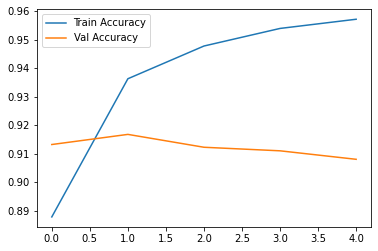

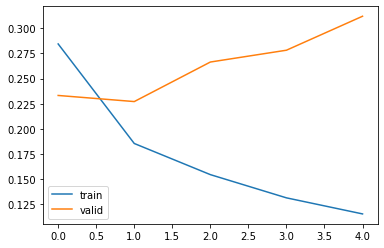

accuracy: 90.80%
Epoch 1/5
733/733 [==============================] - 330s 450ms/step - loss: 0.2867 - accuracy: 0.8850 - val_loss: 0.2245 - val_accuracy: 0.9206
Epoch 2/5
733/733 [==============================] - 348s 474ms/step - loss: 0.1870 - accuracy: 0.9354 - val_loss: 0.2302 - val_accuracy: 0.9168
Epoch 3/5
733/733 [==============================] - 337s 459ms/step - loss: 0.1533 - accuracy: 0.9471 - val_loss: 0.2479 - val_accuracy: 0.9160
Epoch 4/5
733/733 [==============================] - 310s 423ms/step - loss: 0.1308 - accuracy: 0.9533 - val_loss: 0.2727 - val_accuracy: 0.9115
Epoch 5/5
733/733 [==============================] - 315s 430ms/step - loss: 0.1137 - accuracy: 0.9571 - val_loss: 0.3346 - val_accuracy: 0.9096


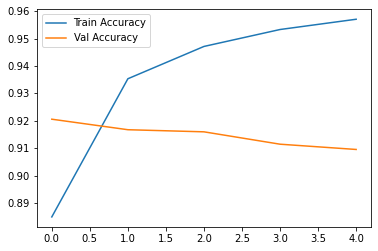

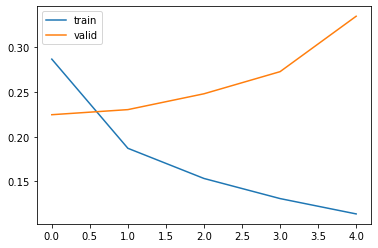

accuracy: 90.96%
Epoch 1/5
733/733 [==============================] - 320s 437ms/step - loss: 0.2869 - accuracy: 0.8852 - val_loss: 0.2197 - val_accuracy: 0.9224
Epoch 2/5
733/733 [==============================] - 326s 444ms/step - loss: 0.1879 - accuracy: 0.9349 - val_loss: 0.2180 - val_accuracy: 0.9214
Epoch 3/5
733/733 [==============================] - 324s 442ms/step - loss: 0.1555 - accuracy: 0.9465 - val_loss: 0.2462 - val_accuracy: 0.9172
Epoch 4/5
733/733 [==============================] - 325s 443ms/step - loss: 0.1342 - accuracy: 0.9526 - val_loss: 0.2609 - val_accuracy: 0.9166
Epoch 5/5
733/733 [==============================] - 326s 445ms/step - loss: 0.1176 - accuracy: 0.9559 - val_loss: 0.3084 - val_accuracy: 0.9129


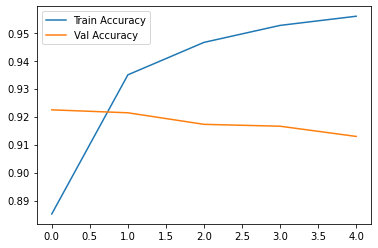

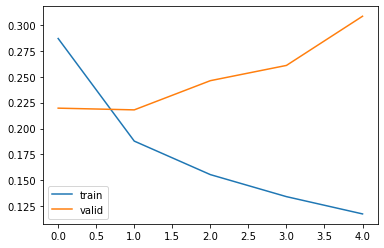

accuracy: 91.29%
Epoch 1/5
733/733 [==============================] - 367s 501ms/step - loss: 0.2846 - accuracy: 0.8859 - val_loss: 0.2346 - val_accuracy: 0.9171
Epoch 2/5
733/733 [==============================] - 391s 533ms/step - loss: 0.1865 - accuracy: 0.9357 - val_loss: 0.2366 - val_accuracy: 0.9171
Epoch 3/5
733/733 [==============================] - 376s 513ms/step - loss: 0.1527 - accuracy: 0.9481 - val_loss: 0.2519 - val_accuracy: 0.9123
Epoch 4/5
733/733 [==============================] - 373s 509ms/step - loss: 0.1306 - accuracy: 0.9546 - val_loss: 0.2836 - val_accuracy: 0.9114
Epoch 5/5
733/733 [==============================] - 377s 515ms/step - loss: 0.1159 - accuracy: 0.9569 - val_loss: 0.3081 - val_accuracy: 0.9097


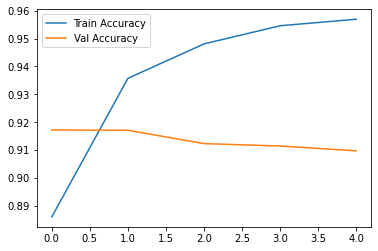

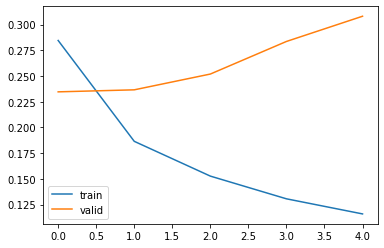

accuracy: 90.97%
90.91% (+/- 0.27%)


In [18]:
from keras.models import Sequential
from keras.layers import Embedding,Bidirectional, Dense,Dropout
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Dropout
kfold = StratifiedKFold(n_splits=10, shuffle=True)
cvscores = []

for train, test in kfold.split(X_vec_v1,Y_vec_v1):
    ## Creating model
    embedding_vector_features=128
    model1=Sequential()
    model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
    model1.add(SpatialDropout1D(0.4))
    model1.add(Bidirectional(LSTM(256)))
    model1.add(Dropout(0.2))
    model1.add(Dense(2,activation='softmax'))
    model1.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    # Fit the model
    history = model1.fit(X_vec_v1[train], Y_vec_v1[train],validation_data=(X_vec_v1[test],Y_vec_v1[test]),epochs=5,batch_size=128)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Train Accuracy', 'Val Accuracy'])
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train', 'valid'])
    plt.show()
    
    # model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=64)
    # evaluate the model
    scores = model1.evaluate(X_vec_v1[test], Y_vec_v1[test], verbose=0)
    print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [19]:
y_pred=model1.predict_classes(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


0.9589746871899901

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     15578
           1       0.93      0.99      0.96     15671

    accuracy                           0.96     31249
   macro avg       0.96      0.96      0.96     31249
weighted avg       0.96      0.96      0.96     31249



In [ ]:
# Training and testing Accuracy, Loss Visualization

In [77]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Dropout
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cvscores = []


In [78]:
for train_index, test_index in kfold.split(X_vec_v1,Y_vec_v1):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train2, X_test2 = X_vec_v1[train_index], X_vec_v1[test_index]
    y_train2, y_test2 = Y_vec_v1[train_index], Y_vec_v1[test_index]

In [79]:
embedding_vector_features=128
model2=Sequential()
model2.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model2.add(SpatialDropout1D(0.4))
model2.add(Bidirectional(LSTM(356)))
model2.add(Dropout(0.2))
model2.add(Dense(2,activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model2.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 20, 128)           2560000   
_________________________________________________________________
spatial_dropout1d_19 (Spatia (None, 20, 128)           0         
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 712)               1381280   
_________________________________________________________________
dropout_22 (Dropout)         (None, 712)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 1426      
Total params: 3,942,706
Trainable params: 3,942,706
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
history = model2.fit(X_train2,y_train2,validation_data=(X_test2,y_test2),epochs=5,batch_size=128)

Epoch 1/5
652/652 [==============================] - 339s 521ms/step - loss: 0.2952 - accuracy: 0.8800 - val_loss: 0.2359 - val_accuracy: 0.9138
Epoch 2/5
652/652 [==============================] - 356s 546ms/step - loss: 0.1878 - accuracy: 0.9342 - val_loss: 0.2498 - val_accuracy: 0.9133
Epoch 3/5
652/652 [==============================] - 394s 604ms/step - loss: 0.1520 - accuracy: 0.9481 - val_loss: 0.2550 - val_accuracy: 0.9072
Epoch 4/5
652/652 [==============================] - 378s 580ms/step - loss: 0.1290 - accuracy: 0.9539 - val_loss: 0.3025 - val_accuracy: 0.9080
Epoch 5/5
652/652 [==============================] - 383s 588ms/step - loss: 0.1137 - accuracy: 0.9576 - val_loss: 0.3282 - val_accuracy: 0.9028


In [89]:
y_pred=model2.predict_classes(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9518176295680532

In [90]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     15524
           1       0.93      0.98      0.95     15753

    accuracy                           0.95     31277
   macro avg       0.95      0.95      0.95     31277
weighted avg       0.95      0.95      0.95     31277



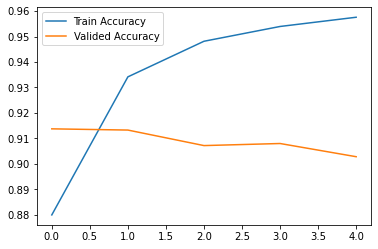

In [83]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train Accuracy', 'Valided Accuracy'])
plt.show()

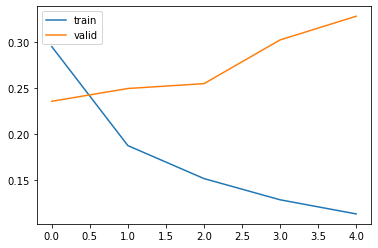

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'valid'])
plt.show()